In [110]:
import warnings
warnings.filterwarnings("ignore")

# Data handling
import numpy as np
import pandas as pd
import math
from itertools import product
from itertools import combinations

# Data visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

# ML models and utilities
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Categorical encoding
import category_encoders as ce

# Hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [111]:
df = pd.read_csv("data/insurance.csv")
df = df.drop('index', axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [113]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [114]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_features)

print("\nNumerical Features:")
print(numerical_features)

Categorical Features:
['sex', 'smoker', 'region']

Numerical Features:
['age', 'bmi', 'children', 'charges']


In [115]:
# Define the target and feature set
X = df.drop('charges', axis=1)  # Features
y = df['charges']  # Target

# One-Hot Encode categorical features
encoder = ce.OneHotEncoder(cols=['sex', 'smoker', 'region'], use_cat_names=True)
X_encoded = encoder.fit_transform(X)

# Add the target 'charges' back into the DataFrame for correlation calculation
X_encoded['charges'] = y

# Calculate correlation matrix
corr = X_encoded.corr()
corr

,age,sex_female,sex_male,bmi,children,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast,charges
age,1.000000,0.020856,-0.020856,0.109272,0.042469,-0.025019,0.025019,0.010016,-0.011642,-0.000407,0.002475,0.299008
sex_female,0.020856,1.000000,-1.000000,-0.046371,-0.017163,-0.076185,0.076185,0.004184,-0.017117,0.011156,0.002425,-0.057292
sex_male,-0.020856,-1.000000,1.000000,0.046371,0.017163,0.076185,-0.076185,-0.004184,0.017117,-0.011156,-0.002425,0.057292
bmi,0.109272,-0.046371,0.046371,1.000000,0.012759,0.003750,-0.003750,-0.006205,0.270025,-0.135996,-0.138156,0.198341
children,0.042469,-0.017163,0.017163,0.012759,1.000000,0.007673,-0.007673,0.021914,-0.023066,0.024806,-0.022808,0.067998
smoker_yes,-0.025019,-0.076185,0.076185,0.003750,0.007673,1.000000,-1.000000,-0.036945,0.068498,-0.036945,0.002811,0.787251
smoker_no,0.025019,0.076185,-0.076185,-0.003750,-0.007673,-1.000000,1.000000,0.036945,-0.068498,0.036945,-0.002811,-0.787251
region_southwest,0.010016,0.004184,-0.004184,-0.006205,0.021914,-0.036945,0.036945,1.000000,-0.346265,-0.320829,-0.320177,-0.043210
region_southeast,-0.011642,-0.017117,0.017117,0.270025,-0.023066,0.068498,-0.068498,-0.346265,1.000000,-0.346265,-0.345561,0.073982
region_northwest,-0.000407,0.011156,-0.011156,-0.135996,0.024806,-0.036945,0.036945,-0.320829,-0.346265,1.000000,-0.320177,-0.039905


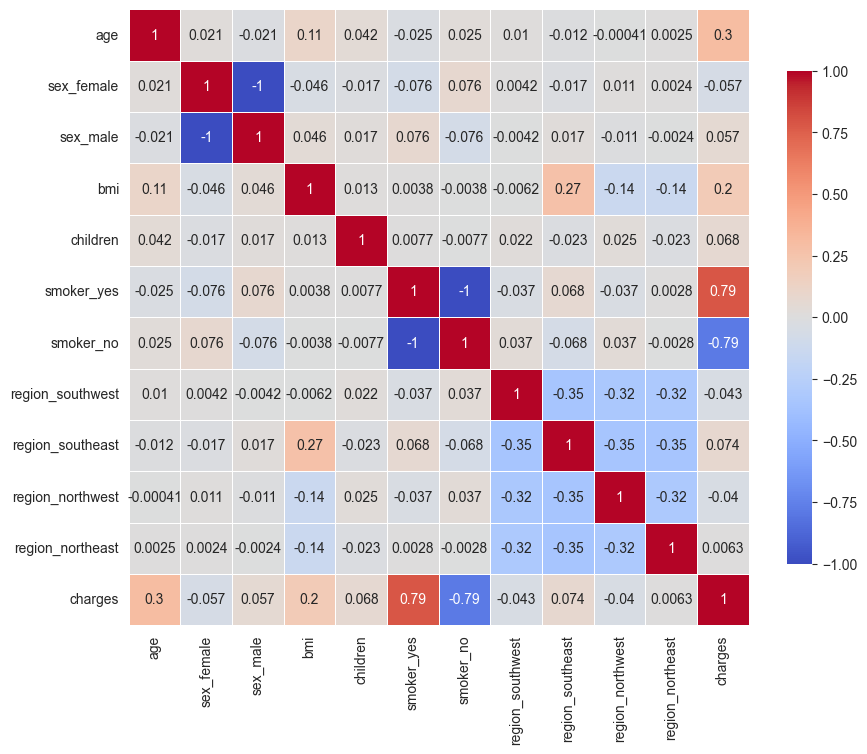

In [116]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.5, center=0, cbar_kws={"shrink": 0.8})
plt.show()

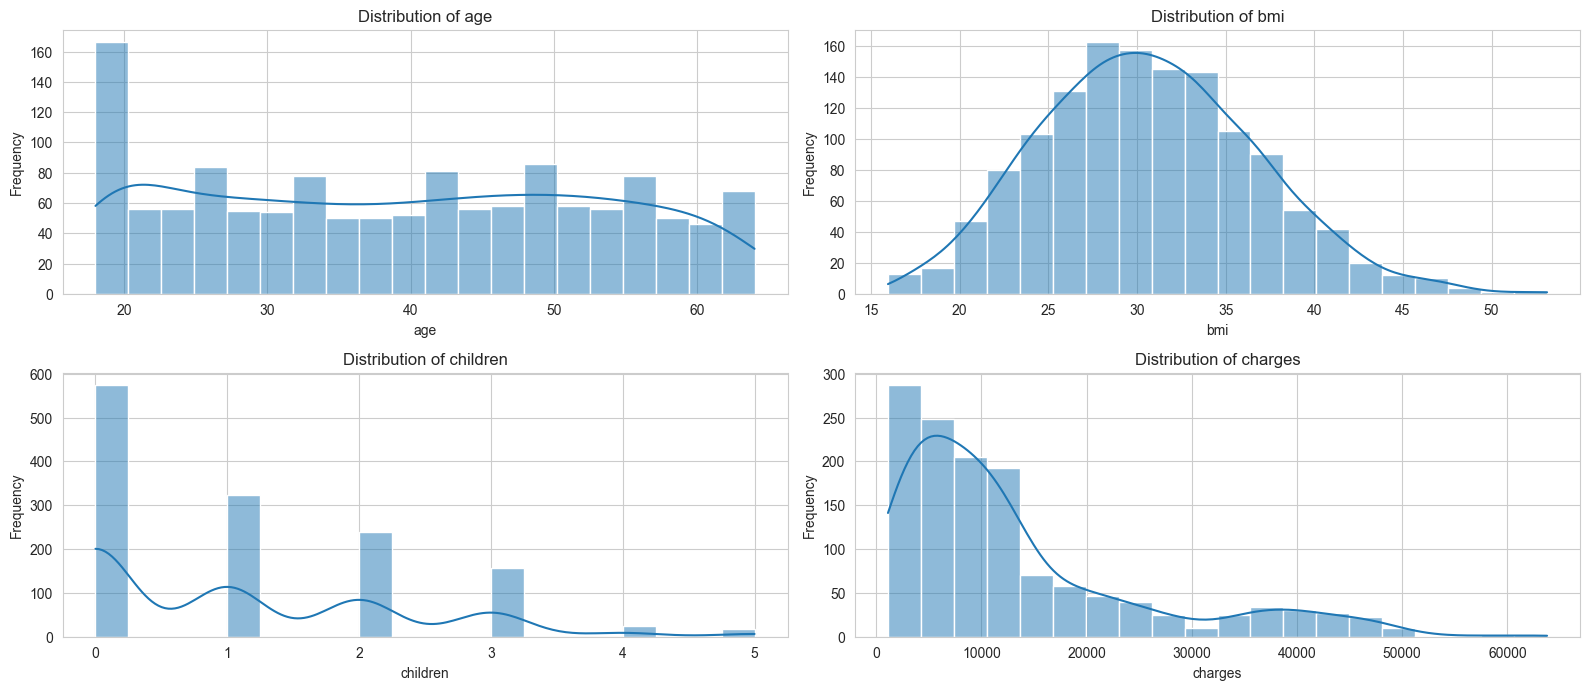

In [117]:
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], kde=True, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

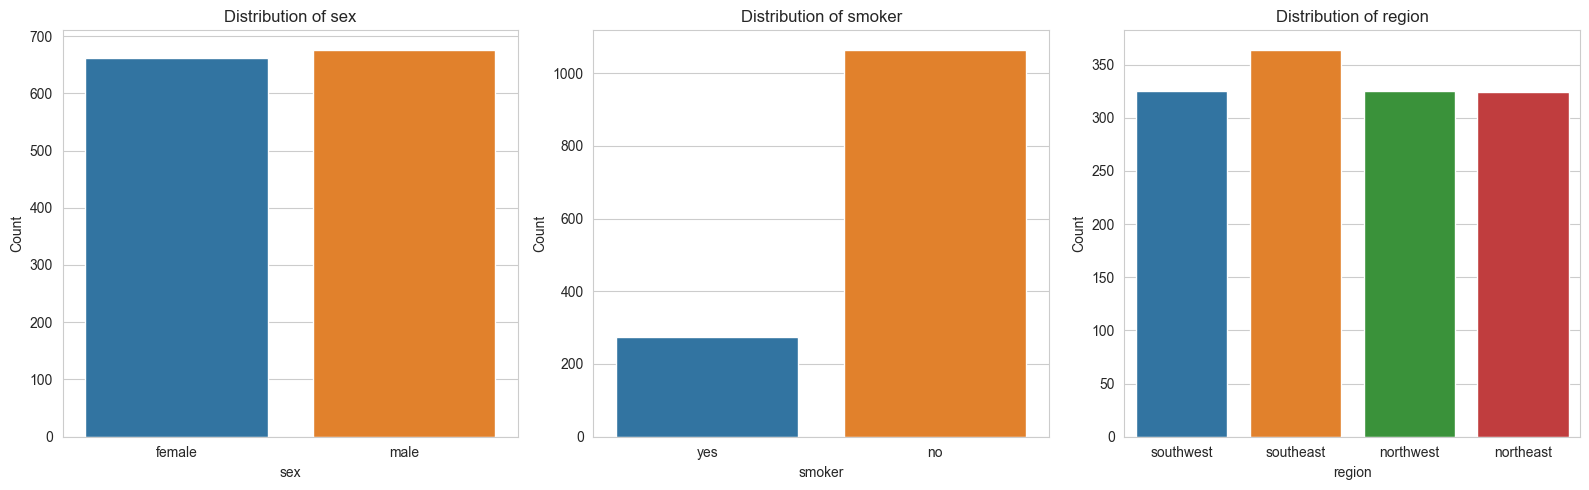

In [118]:
plt.figure(figsize=(16, 5))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [119]:
def plot_paired_scatterplots(X, y):
    data = pd.concat([X, y], axis=1)
    
    num_cols = X.select_dtypes(np.number).columns
    cat_cols = X.select_dtypes(include='object').columns
    
    for cat in cat_cols:
        for num in num_cols:
            fig = px.scatter(data, x=num, y=y.name, 
                             color=cat, 
                             title=f'Scatter plot of {num} vs insurance {y.name} colored by {cat}', 
                             labels={num: num, y.name: y.name})
            fig.show()

In [120]:
plot_paired_scatterplots(X, y)

In [121]:
def perform_anova(data, target, categorical_features):
    anova_results = {}
    
    for cat in categorical_features:
        formula = f'{target} ~ C({cat})'
        model = ols(formula, data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[cat] = anova_table
    
    return anova_results

In [122]:
anova_results = perform_anova(df, 'charges', categorical_features)
for cat, result in anova_results.items():
    print(f"ANOVA results for {cat}:\n", result, "\n")

ANOVA results for sex:
                 sum_sq      df         F    PR(>F)
C(sex)    6.435902e+08     1.0  4.399702  0.036133
Residual  1.954306e+11  1336.0       NaN       NaN 

ANOVA results for smoker:
                  sum_sq      df            F         PR(>F)
C(smoker)  1.215199e+11     1.0  2177.614868  8.271436e-283
Residual   7.455432e+10  1336.0          NaN            NaN 

ANOVA results for region:
                  sum_sq      df         F    PR(>F)
C(region)  1.300760e+09     3.0  2.969627  0.030893
Residual   1.947735e+11  1334.0       NaN       NaN 


In [123]:
def perform_chi2_for_all_pairs(data, categorical_features):
    chi2_results = {}

    # Create combinations of all pairs of categorical features
    for cat1, cat2 in combinations(categorical_features, 2):
        contingency_table = pd.crosstab(data[cat1], data[cat2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Store the results in the dictionary
        chi2_results[f"{cat1} vs {cat2}"] = {
            'Chi2 Statistic': chi2,
            'p-value': p,
            'Degrees of Freedom': dof,
            'Expected Frequencies': expected
        }
    
    return chi2_results

In [124]:
chi2_results = perform_chi2_for_all_pairs(df, categorical_features)

for pair, result in chi2_results.items():
    print(f"Chi-squared Test for {pair}:\nChi2: {result['Chi2 Statistic']}, p-value: {result['p-value']}, Degrees of freedom: {result['Degrees of Freedom']}\n")

Chi-squared Test for sex vs smoker:
Chi2: 7.39291081459996, p-value: 0.006548143503580696, Degrees of freedom: 1

Chi-squared Test for sex vs region:
Chi2: 0.43513679354327284, p-value: 0.9328921288772233, Degrees of freedom: 3

Chi-squared Test for smoker vs region:
Chi2: 7.34347776140707, p-value: 0.06171954839170547, Degrees of freedom: 3


In [125]:
X_encoded['sex_male_x_smoker_yes'] = X_encoded['sex_male'] * X_encoded['smoker_yes']

In [126]:
y = X_encoded['charges']
X = X_encoded.drop('charges', axis=1)
X

,age,sex_female,sex_male,bmi,children,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast,sex_male_x_smoker_yes
0,19,1,0,27.900,0,1,0,1,0,0,0,0
1,18,0,1,33.770,1,0,1,0,1,0,0,0
2,28,0,1,33.000,3,0,1,0,1,0,0,0
3,33,0,1,22.705,0,0,1,0,0,1,0,0
4,32,0,1,28.880,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,0,1,30.970,3,0,1,0,0,1,0,0
1334,18,1,0,31.920,0,0,1,0,0,0,1,0
1335,18,1,0,36.850,0,0,1,0,1,0,0,0
1336,21,1,0,25.800,0,0,1,1,0,0,0,0


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model with the transformed target
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"Model R-squared score: {score}")

insuranceCheck = LogisticRegression()
insuranceCheck.fit(X_train, y_train)
score2 = insuranceCheck.score(X_test, y_test)

print(f"Model R-squared score: {score2}")

Model R-squared score: 0.7837419894068216


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.